# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [3]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [5]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x587509) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

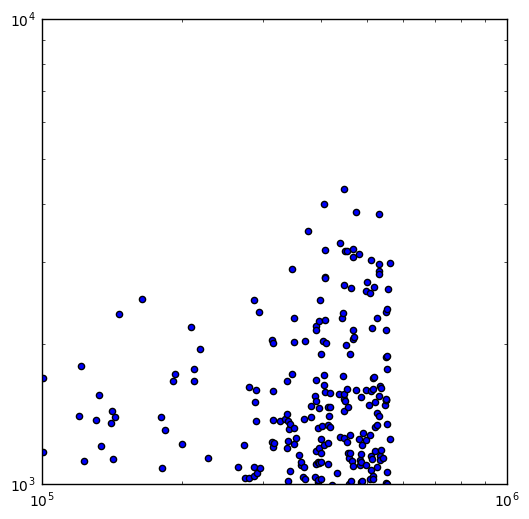

In [6]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    
    pl.figure(figsize=(6,6), dpi=10)
    amounts = np.array((x!=0).sum(0)).flatten()
    pl.scatter(range(len(amounts)), amounts)
    
    pl.yscale('log')
    pl.xscale('log')
    pl.show()
    
    return amounts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [7]:
print features_counts[features_counts > 100].shape

(4166,)


In [8]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [9]:
USER_NAME = "b.lestsov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [10]:
class MyLR:
    def __init__(self):
        self.h = lambda x, theta: 1.0/(1 + np.math.exp(x.dot(theta)))
        
    def _costf1(self, X, Y, theta):
        tmp = self.h(X, theta)
        return -Y * np.math.log(tmp) - (1 - y) * np.math.log(1-tmp)
        
        
    def _costfN(self, X_arr, Y_arr, theta):
        return 1.0/self.len_x * np.sum([self._costf1(X_arr[i], Y_arr[i], self.theta) for i in xrange(self.x_len)])
        
        
    def fit(self, X, Y):
        self.x_len = len(X)
        # Тут я понял, что нужно считать Гессианы и обратые к им :(
        # А в Theano я не умею T_T
    
    def predict_proba(self, X):
        pass
    

In [11]:
from sklearn.linear_model import LogisticRegression as LR
# Я Data-scientist

In [12]:
class LogisticRegression():
    def __init__(self, *args, **kwargs):
        self.solver = LR(*args, **kwargs)
    
    def fit(self, X, Y=None):
        self.solver.fit(X, Y)
        return self
    
    def predict(self, X):
        return self.solver.predict(X)
    
    def predict_proba(self, X):
        return self.solver.predict_proba(X)

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Я Data-scientist

In [14]:
def auroc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob)

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [16]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X1, X_test, Y, Y_test):
    best_fit = 0.0;
    best_C = 0;
    for c in C:
        a = LogisticRegression(C=c, penalty='l2', solver='newton-cg')
        a.fit(X1, Y)
        pred = a.predict_proba(X_test)
        cur_fit = auroc(Y, pred[:,1])
        if cur_fit > best_fit:
            best_fit = cur_fit
            best_C = c
    return c

t = len(X1)/5
opt_C = select_reg_parameter(C, X1[:(len(X1)-t)], X1[t:], Y[:(len(X1)-t)], Y[t:])
print opt_C


10000


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

ROU AUC SCORE:  0.99880089215


/home/boris/my_programs/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


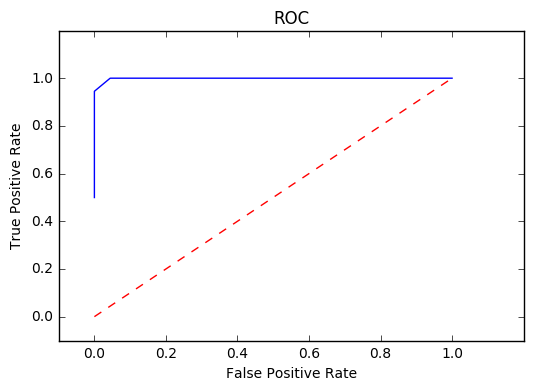

In [17]:
def classify(C, X, X_test, Y, Y_test):
    a = LogisticRegression(C=C, penalty='l2', solver='newton-cg')
    a.fit(X, Y)
    pred = a.predict_proba(X)
    fit = auroc(Y, pred[:,1])
    return roc_curve(Y, pred[:,1]) + (fit,)

fpr, tpr, threshold, fit = classify(opt_C, X1[:(len(X1)-t)], X1[t:], Y[:(len(X1)-t)], Y[t:])

print "ROU AUC SCORE: ", fit

def plot_roc_curve(tpr, fpr):
    """Plot ROC curve"""
    pl.title('ROC')
    plt.plot(fpr, tpr, 'b')
    pl.legend(loc='lower right')
    pl.plot([0,1],[0,1],'r--')
    pl.xlim([-0.1,1.2])
    pl.ylim([-0.1,1.2])
    pl.ylabel('True Positive Rate')
    pl.xlabel('False Positive Rate')
    pl.show()
    return

plot_roc_curve(tpr, fpr)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.